This uses ChemCam cleaned, calibrated spectra from the PDS repository. The data is given in csv format with the first column being the wavelength and the following columns representing the intensities measured in units of photons per channels for each of the $n$ shots.

In [94]:
import pandas as pd
from pathlib import Path

In [95]:
data_path = Path("data/2014_06_24_134251_ccs.csv")

with open(data_path) as f:
    data = pd.read_csv(f, skiprows=14)

# strip whitespace from column names
data.columns = data.columns.str.strip()
# remove # from column names
data.columns = data.columns.str.replace("# ", "")
# remove negative values in all columns that contains "shot"
data.loc[:, data.columns.str.contains("shot")] = data.loc[:, data.columns.str.contains("shot")].clip(lower=0)
# dropna
data.dropna(inplace=True)

In [96]:
data["Avg"] = data[[col for col in data.columns if "shot" in col]].mean(axis=1)
data.head()

,wave,shot1,shot2,shot3,shot4,shot5,shot6,shot7,shot8,shot9,...,shot44,shot45,shot46,shot47,shot48,shot49,shot50,median,mean,Avg
0,240.81100,3.880170e+15,4.091744e+15,8.254170e+15,9.809446e+15,7.101064e+15,7.852098e+15,9.983202e+15,1.222081e+16,9.899956e+15,...,6.942179e+15,7.154902e+15,7.041416e+15,6.085985e+15,5.882914e+15,6.416093e+15,6.895508e+15,8.271515e+15,7.547147e+15,7.506307e+15
1,240.86501,3.591573e+12,3.482102e+12,5.976025e+12,6.706981e+12,3.657451e+12,4.080802e+12,4.692521e+12,6.057462e+12,4.131306e+12,...,4.443926e+12,4.523055e+12,4.466811e+12,3.996626e+12,2.771725e+12,4.186176e+12,4.471553e+12,4.002203e+12,3.696544e+12,4.381112e+12
2,240.91800,6.837214e+11,6.380011e+11,9.460191e+11,8.475670e+11,5.026804e+11,7.289909e+11,6.271218e+11,8.362657e+11,6.081577e+11,...,6.302432e+11,6.626754e+11,6.518938e+11,6.277546e+11,3.642780e+11,6.531344e+11,6.834426e+11,5.834341e+11,5.283353e+11,6.331796e+11
3,240.97200,9.664501e+11,9.703370e+11,1.365459e+12,1.358214e+12,1.045686e+12,1.298425e+12,1.240897e+12,1.594409e+12,1.284735e+12,...,9.098925e+11,9.659302e+11,9.563608e+11,9.391604e+11,8.025714e+11,9.692956e+11,1.010836e+12,1.085822e+12,9.715835e+11,1.041577e+12
4,241.02699,1.188238e+12,1.370789e+12,2.101685e+12,2.374514e+12,1.730013e+12,1.936763e+12,2.012970e+12,2.633561e+12,2.265499e+12,...,1.343772e+12,1.417734e+12,1.463602e+12,1.389402e+12,1.370563e+12,1.415418e+12,1.459421e+12,1.857943e+12,1.664210e+12,1.633114e+12


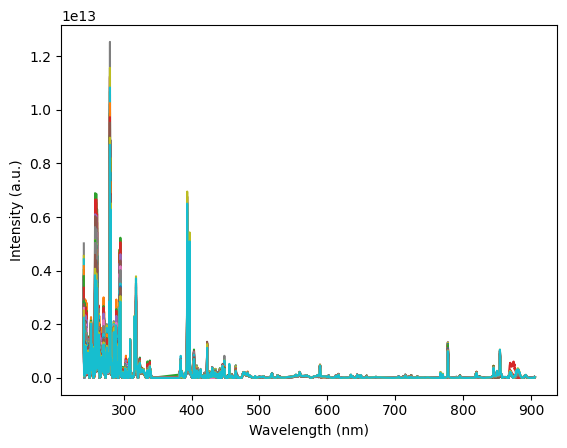

In [97]:
# plot avg. of all shots (y) over wavelength (x)
import matplotlib.pyplot as plt

# drop first row
data = data.iloc[1:]

data["Avg"] = data[[col for col in data.columns if "shot" in col]].mean(axis=1)

shots = [col for col in data.columns if "shot" in col]
data_shots = data[shots]
# drop first 5 shots
data_shots = data_shots.iloc[5:]

plt.plot(data["wave"].iloc[5:], data_shots)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)") # a.u. = arbitrary units
plt.show()
